# Imports

In [1]:
!pip install /kaggle/input/pythongdcm/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/pythongdcm/python_gdcm-3.0.21-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import os
import cv2
from torch import Tensor
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader
import pydicom
from pathlib import Path
from PIL import Image

# Checks for cuda

In [3]:
print("Cuda available: " + str(torch.cuda.is_available()))
print("Cuda enabled: " + str(torch.backends.cudnn.enabled))

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print("Compute device: " + str(device))

Cuda available: True
Cuda enabled: True
Compute device: cuda


# Loads processed image data 

In [4]:
image_data = {}

In [5]:
image_data_dir = '/kaggle/input/rsna-breast-cancer-detection-processed-256/train_images_processed_256'

In [6]:
def load_image(patient_id, image_id):
    image = cv2.imread(os.path.join(image_data_dir, str(int(patient_id)), str(int(image_id)) + '.png'), cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float16)
    image = image / 255.0
    return image

In [7]:
def load_patient_images(patient_id):
    image_data[int(patient_id)] = {}
    for image_name in os.listdir(os.path.join(image_data_dir, patient_id)):
        image_id = int(image_name.split('.')[0])
        image_data[int(patient_id)][image_id] = load_image(patient_id, image_id)

In [8]:
#for patient_id in os.listdir(image_data_dir):
#    load_patient_images(patient_id)

In [9]:
#len(image_data)

In [10]:
#plt.imshow(image_data[10006][1459541791])
#plt.show()

# Loads tabulare data

In [11]:
df_train_og =  pd.read_csv('../input/rsna-breast-cancer-detection/train.csv')
df_test = pd.read_csv('../input/rsna-breast-cancer-detection/test.csv')

### Check for null values

In [12]:
df_train_og.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [13]:
# we only fixed null values for age, BIRADS and density columns will be droped
mean = df_train_og['age'].mean()
df_train_og['age'] = df_train_og['age'].fillna(mean)
df_test['age'] = df_test['age'].fillna(mean)

In [14]:
df_train_og.describe()

site_id    patient_id      image_id           age        cancer  \
count  54706.000000  54706.000000  5.470600e+04  54706.000000  54706.000000   
mean       1.460407  32698.865262  1.079386e+09     58.543928      0.021168   
std        0.498434  18893.861534  6.183269e+08     10.047484      0.143944   
min        1.000000      5.000000  6.849100e+04     26.000000      0.000000   
25%        1.000000  16481.000000  5.458153e+08     51.000000      0.000000   
50%        1.000000  32432.000000  1.082689e+09     59.000000      0.000000   
75%        2.000000  48999.000000  1.613228e+09     66.000000      0.000000   
max        2.000000  65534.000000  2.147472e+09     89.000000      1.000000   

             biopsy      invasive        BIRADS       implant    machine_id  
count  54706.000000  54706.000000  26286.000000  54706.000000  54706.000000  
mean       0.054272      0.014953      0.772350      0.026999     54.618378  
std        0.226556      0.121365      0.590062      0.162081     44.784800  
min        0.000000      0.000000      0.000000      0.000000     21.000000  
25%        0.000000      0.000000      0.000000      0.000000     29.000000  
50%        0.000000      0.000000      1.000000      0.000000     49.000000  
75%        0.000000      0.000000      1.000000      0.000000     49.000000  
max        1.000000      1.000000      2.000000      1.000000    216.000000

In [15]:
df_train_og.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [16]:
df_test.head()

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id  
0       10008_L  
1       10008_L  
2       10008_R  
3       10008_R

In [17]:
pd.read_csv('../input/rsna-breast-cancer-detection/sample_submission.csv').head()

prediction_id    cancer
0       10008_L  0.021168
1       10008_R  0.021168

In [18]:
usefull_data_columns = [
                     'patient_id',
                     'image_id',
                     'laterality',
                     'view',
                     'age',
                     'implant',
                     'cancer']

In [19]:
df_train = df_train_og[usefull_data_columns]

In [20]:
df_train.head()

patient_id    image_id laterality view   age  implant  cancer
0       10006   462822612          L   CC  61.0        0       0
1       10006  1459541791          L  MLO  61.0        0       0
2       10006  1864590858          R  MLO  61.0        0       0
3       10006  1874946579          R   CC  61.0        0       0
4       10011   220375232          L   CC  55.0        0       0

In [21]:
one_hot = pd.get_dummies(df_train['view'])
df_train = (pd.concat([df_train, one_hot], axis=1)).drop('view', axis=1)

one_hot = pd.get_dummies(df_train['laterality'])
df_train = (pd.concat([df_train, one_hot], axis=1)).drop('laterality', axis=1)

In [22]:
#encoder = LabelEncoder()
#df_train['cancer'] = encoder.fit_transform(df_train['cancer'])

In [23]:
#df_train['cancer'] = df_train['cancer'] - 1

In [24]:
df_train

patient_id    image_id   age  implant  cancer  AT  CC  LM  LMO  ML  \
0           10006   462822612  61.0        0       0   0   1   0    0   0   
1           10006  1459541791  61.0        0       0   0   0   0    0   0   
2           10006  1864590858  61.0        0       0   0   0   0    0   0   
3           10006  1874946579  61.0        0       0   0   1   0    0   0   
4           10011   220375232  55.0        0       0   0   1   0    0   0   
...           ...         ...   ...      ...     ...  ..  ..  ..  ...  ..   
54701        9973  1729524723  43.0        0       0   0   0   0    0   0   
54702        9989    63473691  60.0        0       0   0   0   0    0   0   
54703        9989  1078943060  60.0        0       0   0   1   0    0   0   
54704        9989   398038886  60.0        0       0   0   0   0    0   0   
54705        9989   439796429  60.0        0       0   0   1   0    0   0   

       MLO  L  R  
0        0  1  0  
1        1  1  0  
2        1  0  1  
3        0  0  1  
4        0  1  0  
...    ... .. ..  
54701    1  0  1  
54702    1  1  0  
54703    0  1  0  
54704    1  0  1  
54705    0  0  1  

[54706 rows x 13 columns]

# Defines dataset

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, tabluar_data, image_dict):
        self.tabluar_data = tabluar_data
        self.image_dict = image_dict

    def __len__(self):
        return len(self.tabluar_data)

    def __getitem__(self, idx):
        tbd = self.tabluar_data.iloc[idx]
        #image_nparray = self.image_dict[tbd['patient_id']][tbd['image_id']]
        image_nparray = load_image(tbd['patient_id'], tbd['image_id'])
        target = tbd['cancer']
        tbd = tbd.drop(['cancer', 'patient_id', 'image_id']).to_numpy()
        return (torch.tensor(target).to(torch.float32), 
                torch.tensor(tbd).to(torch.float32), 
                torch.tensor(image_nparray).view(1, 256, 256).to(torch.float32))

# Creates data loaders

In [26]:
patients = df_train[['patient_id', 'cancer']]
patients = patients.drop_duplicates(subset='patient_id')

In [27]:
print('n_case:', str(len(patients[patients['cancer'] == 0])), '   p_case:', str(len(patients[patients['cancer'] == 1])))
print('n_case:', str(len(df_train[df_train['cancer'] == 0])), '   p_case:', str(len(df_train[df_train['cancer'] == 1])))

n_case: 11665    p_case: 248
n_case: 53548    p_case: 1158


In [28]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7777)
for train_index, dev_index in sss.split(patients['patient_id'], patients['cancer']):
    train_patients, dev_patients = patients.iloc[train_index], patients.iloc[dev_index]

In [29]:
train_data_df = df_train[df_train['patient_id'].isin(train_patients['patient_id'])]
dev_data_df = df_train[df_train['patient_id'].isin(dev_patients['patient_id'])]

In [30]:
train_data_df['cancer'].value_counts()

0    42801
1      930
Name: cancer, dtype: int64

In [31]:
print('n_case:', str(len(train_patients[train_patients['cancer'] == 0])), '   p_case:', str(len(train_patients[train_patients['cancer'] == 1])))
print('n_case:', str(len(dev_patients[dev_patients['cancer'] == 0])), '   p_case:', str(len(dev_patients[dev_patients['cancer'] == 1])))

n_case: 9332    p_case: 198
n_case: 2333    p_case: 50


In [32]:
print('n_case:', str(len(train_data_df[train_data_df['cancer'] == 0])), '   p_case:', str(len(train_data_df[train_data_df['cancer'] == 1])))
print('n_case:', str(len(dev_data_df[dev_data_df['cancer'] == 0])), '   p_case:', str(len(dev_data_df[dev_data_df['cancer'] == 1])))
print('n_case:', str(len(dev_data_df[dev_data_df['cancer'] == 0]) + len(train_data_df[train_data_df['cancer'] == 0])), 
      '   p_case:', str(len(dev_data_df[dev_data_df['cancer'] == 1]) + len(train_data_df[train_data_df['cancer'] == 1])))

n_case: 42801    p_case: 930
n_case: 10747    p_case: 228
n_case: 53548    p_case: 1158


In [33]:
train_data_set = Dataset(train_data_df, image_data)
dev_data_set = Dataset(dev_data_df, image_data)

In [34]:
train_dl = DataLoader(train_data_set, batch_size=16, shuffle=True, num_workers=2)
dev_dl = DataLoader(dev_data_set, batch_size=16, shuffle=True, num_workers=2)

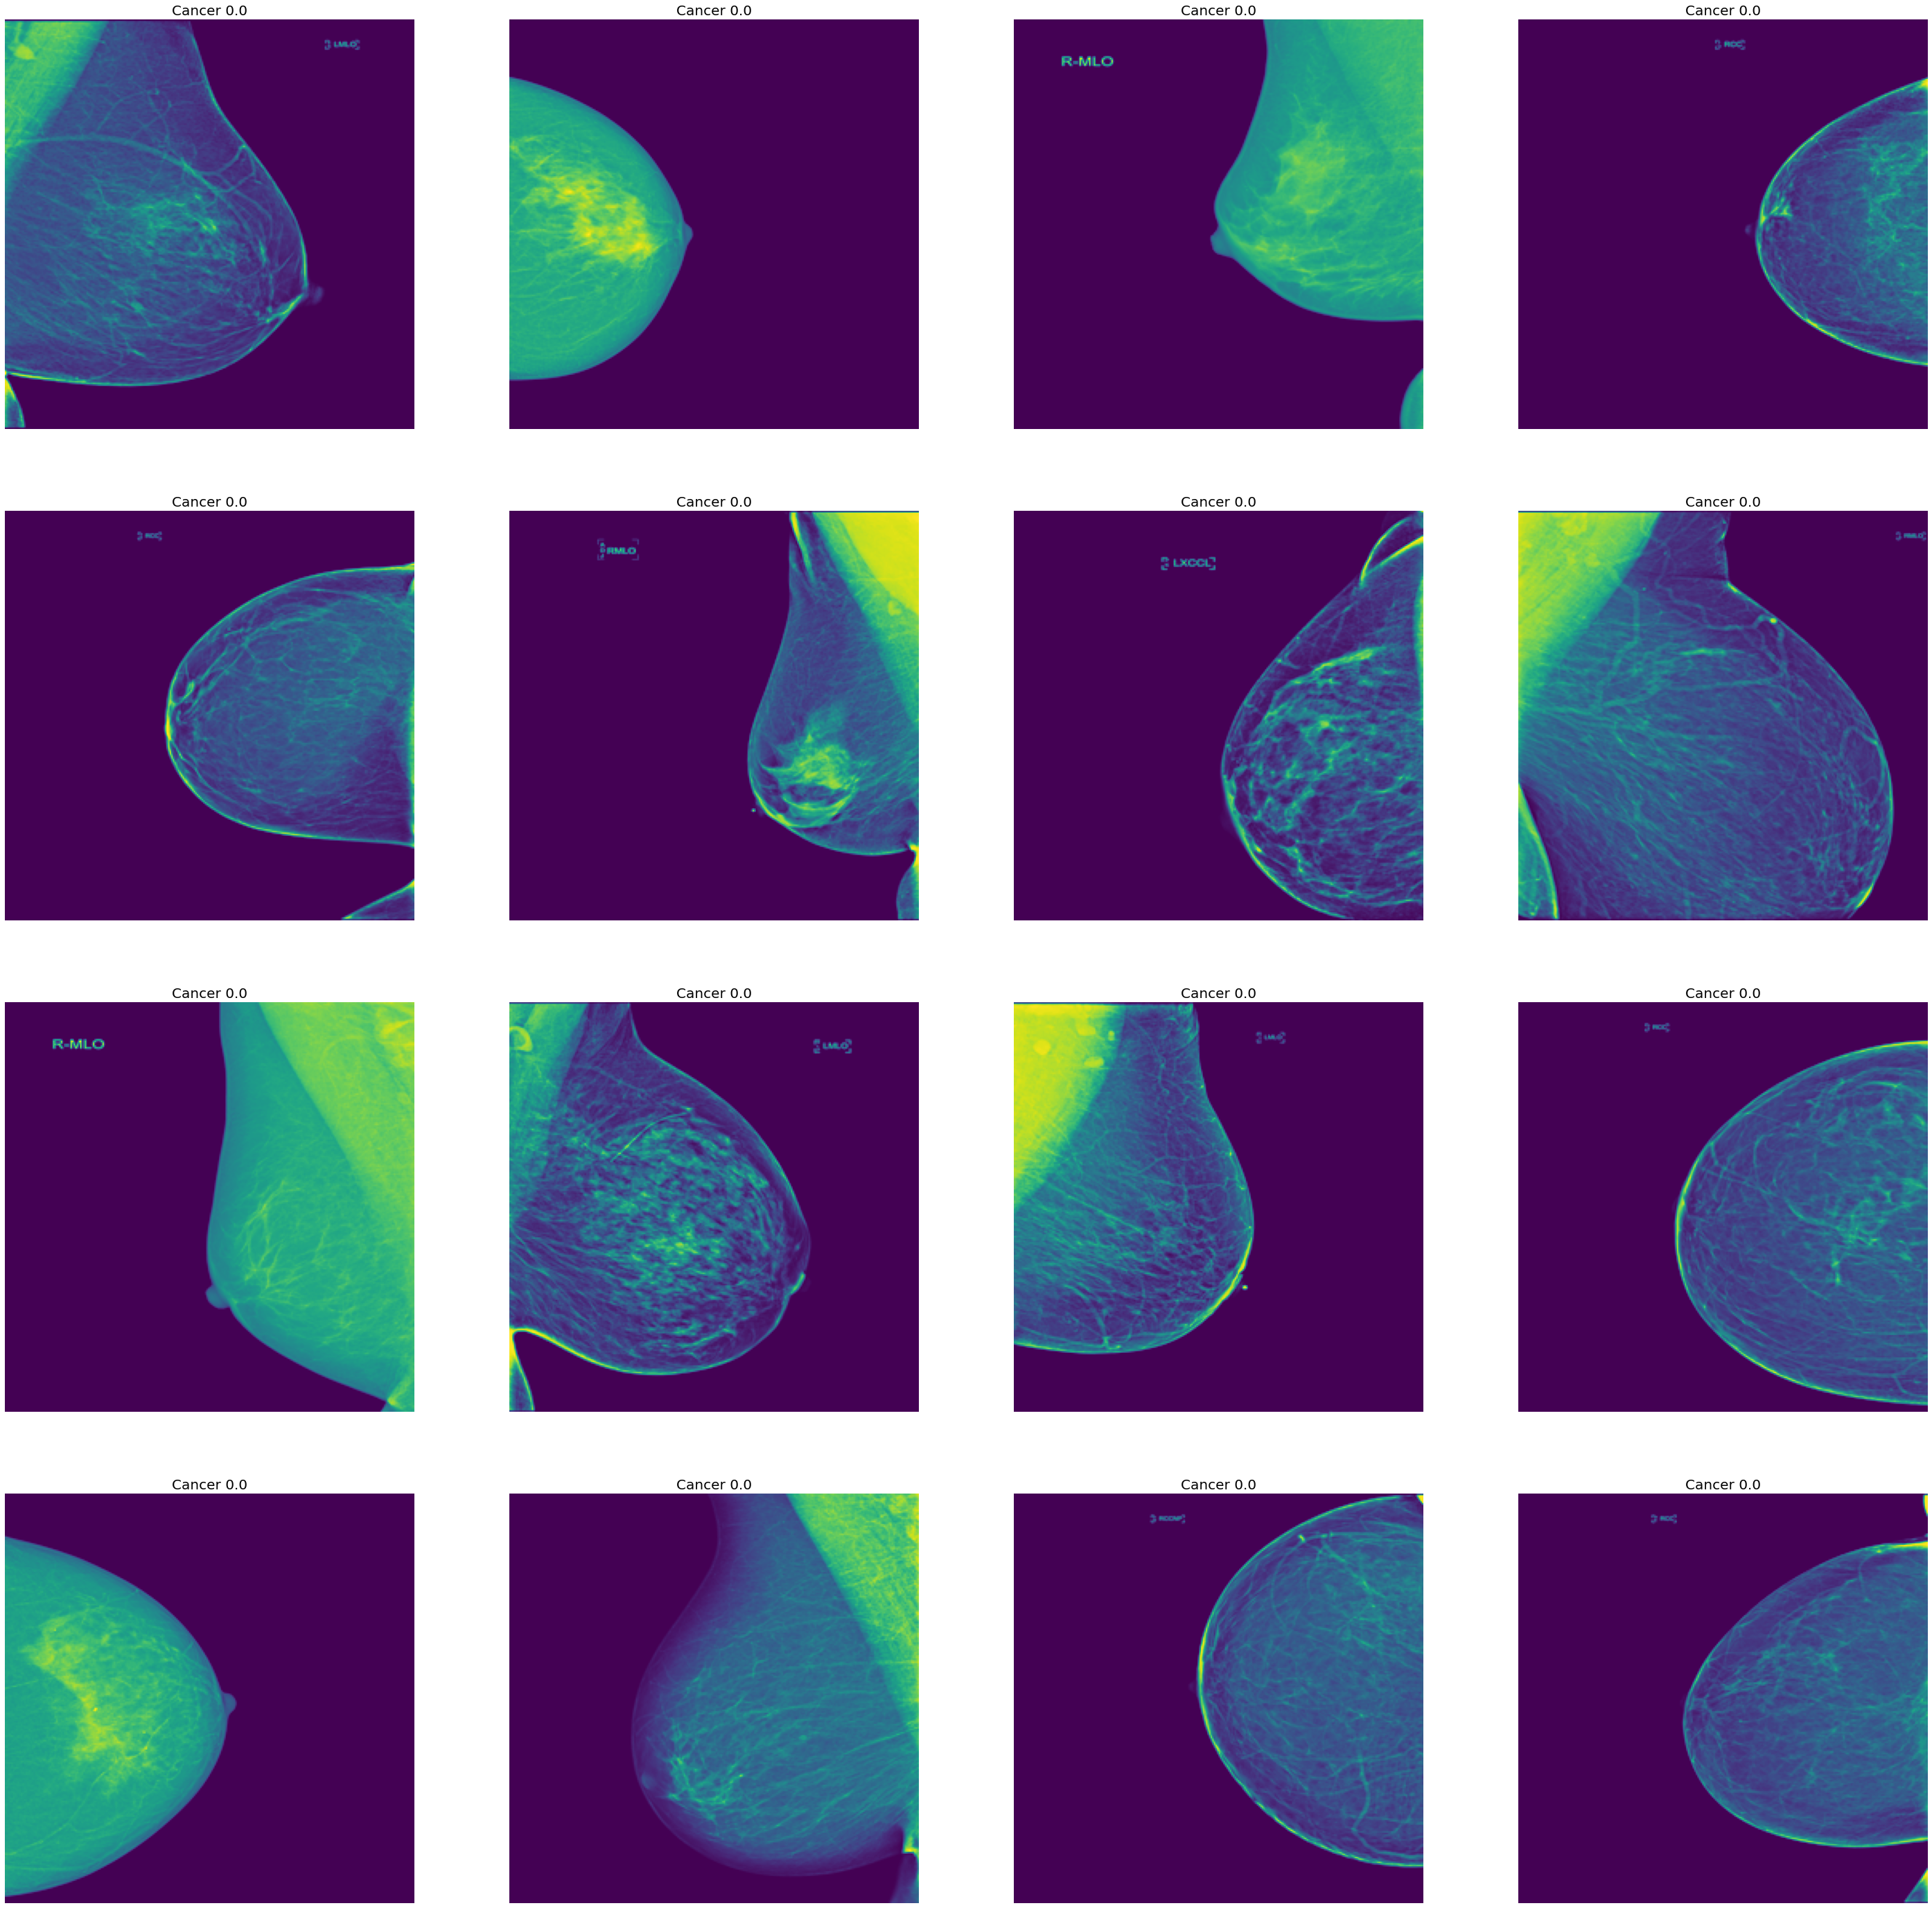

In [35]:
for batch_idx, batch in enumerate(train_dl): 
    target, data, image = batch
    fig, axs = plt.subplots(4, 4, figsize=(50, 50))
    for i, ax in enumerate(axs.flat):
        ax.imshow(image.numpy()[i][0])#, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Cancer {target[i]}', fontsize=20)
    break

# Defines the model

In [36]:
class MyNet(nn.Module):

    def __init__(self):
        super(MyNet, self).__init__()

        self.conv = nn.Sequential(
            #in 256
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #out 252
            
            #in 252
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 248
            
            #in 248
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 244
            
            #in 244
            nn.MaxPool2d(kernel_size=2, stride=2),
            #out 122
            
            #in 122
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 118
            
            #in 118
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 114
            
            #in 114
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 110
            
            #in 110
            nn.MaxPool2d(kernel_size=2, stride=2),
            #out 55
            
            #in 55
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 53
            
            #in 53
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 51
            
            #in 51
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 49
            
            #in 49
            nn.MaxPool2d(kernel_size=2, stride=2),
            #out 24
            
            #in 24
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 22
            
            #in 22
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #out 20
            
            #in 20
            nn.MaxPool2d(kernel_size=2, stride=2),
            #out 10
        )
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=10, out_features=6 * 10),
            nn.BatchNorm1d(6 * 10),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(in_features=6 * 10, out_features=6 * 10 * 10),
            nn.BatchNorm1d(6 * 10 * 10),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        
        self.merg = nn.Sequential(
            # (6 * 10 * 10) + (10 * 10 * 64) = 7000
            nn.Linear(in_features=7000, out_features=10000),
            nn.BatchNorm1d(10000),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=10000, out_features=1000),
            nn.BatchNorm1d(1000),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=1000, out_features=100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=100, out_features=1),
            #nn.ReLU()
        )

    def forward(self, x_img: Tensor, x_tbl) -> Tensor:
        x_img = self.conv(x_img)
        x_img = x_img.view(x_img.size(0), -1)
        
        x_tbl = self.linear(x_tbl)
        
        x = torch.cat((x_img, x_tbl), dim=1)
        x = self.merg(x)
        x = torch.sigmoid(x)
        return x.view(-1)

# Defiens trainer

In [37]:
class MyTrainer:
    def __init__(self, model, optimizer, loss_fn, lr_scheduler):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self._check_optim_net_aligned()

    # Ensures that the given optimizer points to the given model
    def _check_optim_net_aligned(self):
        assert self.optimizer.param_groups[0]['params'] == list(self.model.parameters())

    # Trains the model
    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 50,
            eval_every: int = 1,
            early_stopping: bool = True,
            sub_epoch_logs: bool = False,
            sub_epoch_percentile: float = 0.1,
            simple_report = False):

        # Stores the current best loss, used to abort training early,
        # helps to prevent over-fitting
        best_loss = 1e9
        # Used to perform sub batch eval
        batch_log_every = len(train_dataloader) * sub_epoch_percentile

        for e in range(epochs):
            if not simple_report:
                # Logs learning rate
                print("Current learning rate: {}".format(self.lr_scheduler.get_last_lr()))
            # Make sure gradient tracking is on, and do a pass over the data
            self.model.train(True)

            # Stores data about the batch
            batch_losses = []
            sub_batch_losses = []

            for i, data in enumerate(train_dataloader):
                # Every data instance is an input + label pair
                labels, inputs, image = data
                
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    image = image.cuda()

                # Zero your gradients for every batch!
                self.optimizer.zero_grad()
                # Make predictions for this batch
                outputs = self.model(image, inputs)
                # Compute the loss and its gradients
                loss = self.loss_fn(outputs, labels)
                loss.backward()
                # Adjust learning weights
                self.optimizer.step()

                # Saves data
                #print(i, loss)
                batch_losses.append(loss)
                sub_batch_losses.append(loss)

                # Performs sub batch log
                if sub_epoch_logs and (i + 1) % batch_log_every == 0 and not simple_report:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                        e, (i + 1) * train_dataloader.batch_size,
                        len(train_dataloader) * train_dataloader.batch_size,
                        100.0 * (i + 1) / len(train_dataloader), torch.Tensor(sub_batch_losses).mean()))
                    sub_batch_losses.clear()

            # Adjusts learning rate
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            # Reports on the path
            print('Train Epoch: {} Average Loss: {:.6f}'.format(e, torch.Tensor(batch_losses).mean()))

            # Reports on the training progress
            if (e + 1) % eval_every == 0:
                torch.save(self.model.state_dict(), "model_checkpoint_e" + str(e) + ".pt")
                with torch.no_grad():
                    self.model.eval()
                    losses = []
                    for i, data in enumerate(test_dataloader):
                        # Every data instance is an input + label pair
                        labels, inputs, image = data
                        
                        if torch.cuda.is_available():
                            inputs = inputs.cuda()
                            labels = labels.cuda()
                            image = image.cuda()

                        output = self.model(image, inputs)
                        loss = self.loss_fn(output, labels)
                        losses.append(loss.item())
                    
                    avg_loss = torch.Tensor(losses).mean().item()
                                            
                    if early_stopping:
                        if avg_loss < best_loss:
                            best_loss = avg_loss
                            print("The loss after", (e + 1), "epochs was", round(avg_loss, 4))
                        else:
                            print("The loss after", (e + 1), "epochs was", round(avg_loss, 4))
                            print("The loss had increased since the last checkpoint, aborting training!")
                            # revers to the previse model sice the current one is worse
                            self.model.load_state_dict(torch.load("model_checkpoint_e" + str(e) + ".pt"))
                            break
                    else:
                        print("The loss after", (e + 1), "epochs was:", round(avg_loss, 4))
                    
                    if not simple_report:
                        print()

In [38]:
model = MyNet()
#weights = torch.tensor([1.0, 50.0])
loss_function = torch.nn.BCELoss(weight=torch.tensor(50.))#weight=weights)
#loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)
trainer = MyTrainer(model, optimizer, loss_function, lr_scheduler)

In [39]:
if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

In [40]:
#trainer.fit(train_dl, dev_dl, epochs=3, eval_every=1, 
#    sub_epoch_logs=True, sub_epoch_percentile=0.05, simple_report = False)

In [41]:
torch.save(model.state_dict(), "model" + ".pt")

#  Make prodiction on the test set

#### Process image data

In [42]:
#source: https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs
RESIZE_TO = (256, 256)

def dicom_file_to_ary(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def process_directory(directory_path):
    parent_directory = str(directory_path).split('/')[-1]
    !mkdir -p train_images_processed_{RESIZE_TO[0]}/{parent_directory}
    for image_path in directory_path.iterdir():
        if not (Path(f'train_images_processed_{RESIZE_TO[0]}/{parent_directory}/{image_path.stem}.png')).is_file():
            processed_ary = dicom_file_to_ary(image_path)
            im = Image.fromarray(processed_ary).resize(RESIZE_TO)
            #im.save(f'{image_path.stem}.png')
            im.save(f'train_images_processed_{RESIZE_TO[0]}/{parent_directory}/{image_path.stem}.png')

In [43]:
import multiprocessing as mp

directories = list(Path('../input/rsna-breast-cancer-detection/test_images').iterdir())
print('Began processing image data')
with mp.Pool(2) as p:
    p.map(process_directory, directories)
print('Finished processing image data')

Began processing image data
Finished processing image data


In [44]:
image_data = {}
image_data_dir = '/kaggle/working/train_images_processed_256'

In [45]:
for patient_id in os.listdir(image_data_dir):
    load_patient_images(patient_id)

#### Process tabulare data

In [46]:
# create uuid's for each breast, (two per paitent), should be identical to prediction_id
df_test = pd.read_csv('../input/rsna-breast-cancer-detection/test.csv')
def generate_brest_id(row):
    return str(row['patient_id']) + '_' + row['laterality']
df_test['breast_id'] = df_test.apply(generate_brest_id, axis=1)

In [47]:
# we want to make predoction per breast, not image
breasts = df_test['breast_id'].drop_duplicates()

In [48]:
breasts

0    10008_L
2    10008_R
Name: breast_id, dtype: object

In [49]:
mean = df_test['age'].mean()
df_test['age'] = df_test['age'].fillna(mean)
df_test['age'] = df_test['age'].fillna(mean)

In [50]:
one_hot = pd.get_dummies(df_test['view'])
df_test = (pd.concat([df_test, one_hot], axis=1)).drop('view', axis=1)

one_hot = pd.get_dummies(df_test['laterality'])
df_test = (pd.concat([df_test, one_hot], axis=1)).drop('laterality', axis=1)

In [51]:
df_test

site_id  patient_id    image_id  age  implant  machine_id prediction_id  \
0        2       10008   736471439   81        0          21       10008_L   
1        2       10008  1591370361   81        0          21       10008_L   
2        2       10008    68070693   81        0          21       10008_R   
3        2       10008   361203119   81        0          21       10008_R   

  breast_id  CC  MLO  L  R  
0   10008_L   0    1  1  0  
1   10008_L   1    0  1  0  
2   10008_R   0    1  0  1  
3   10008_R   1    0  0  1

#### Defines test data loader

In [52]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, tabluar_data, image_dict):
        self.tabluar_data = tabluar_data
        self.image_dict = image_dict

    def __len__(self):
        return len(self.tabluar_data)

    def __getitem__(self, idx):
        tbd = self.tabluar_data.iloc[idx]
        image_nparray = self.image_dict[tbd['patient_id']][tbd['image_id']]
        image_nparray = load_image(tbd['patient_id'], tbd['image_id'])
        tbd = tbd.drop(['prediction_id', 'breast_id']).to_numpy() # 'patient_id', 'image_id', 
        tbd = tbd.astype('float32')
        return (torch.tensor(tbd).to(torch.float32), 
                torch.tensor(image_nparray).view(1, 256, 256).to(torch.float32))

#### Make predictions

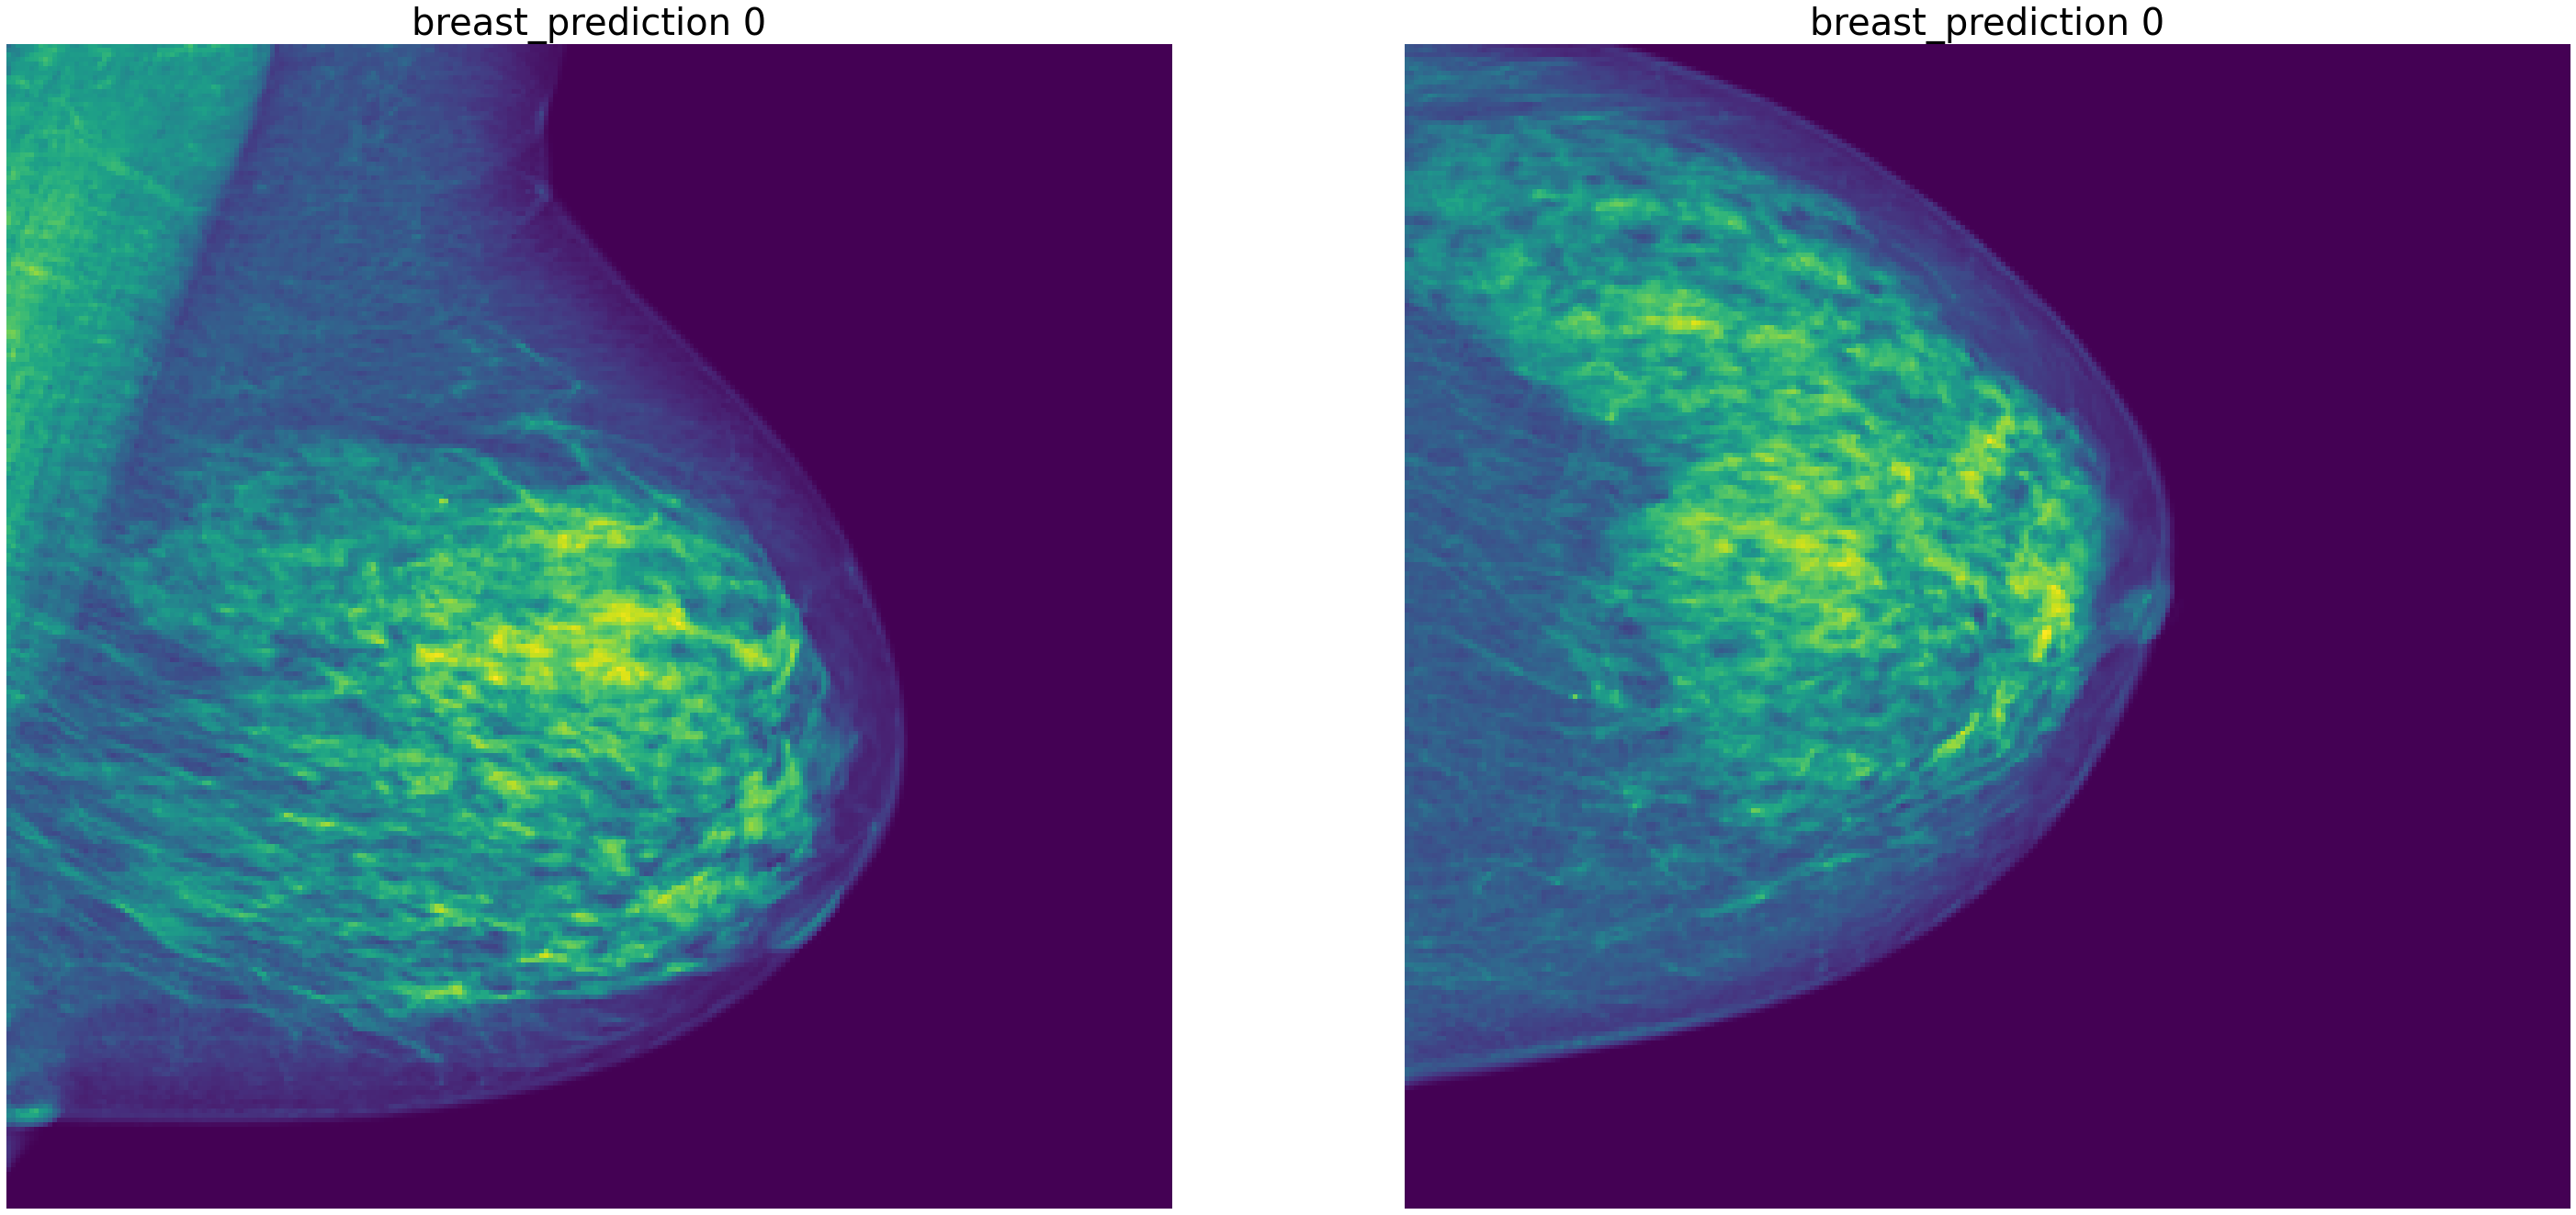

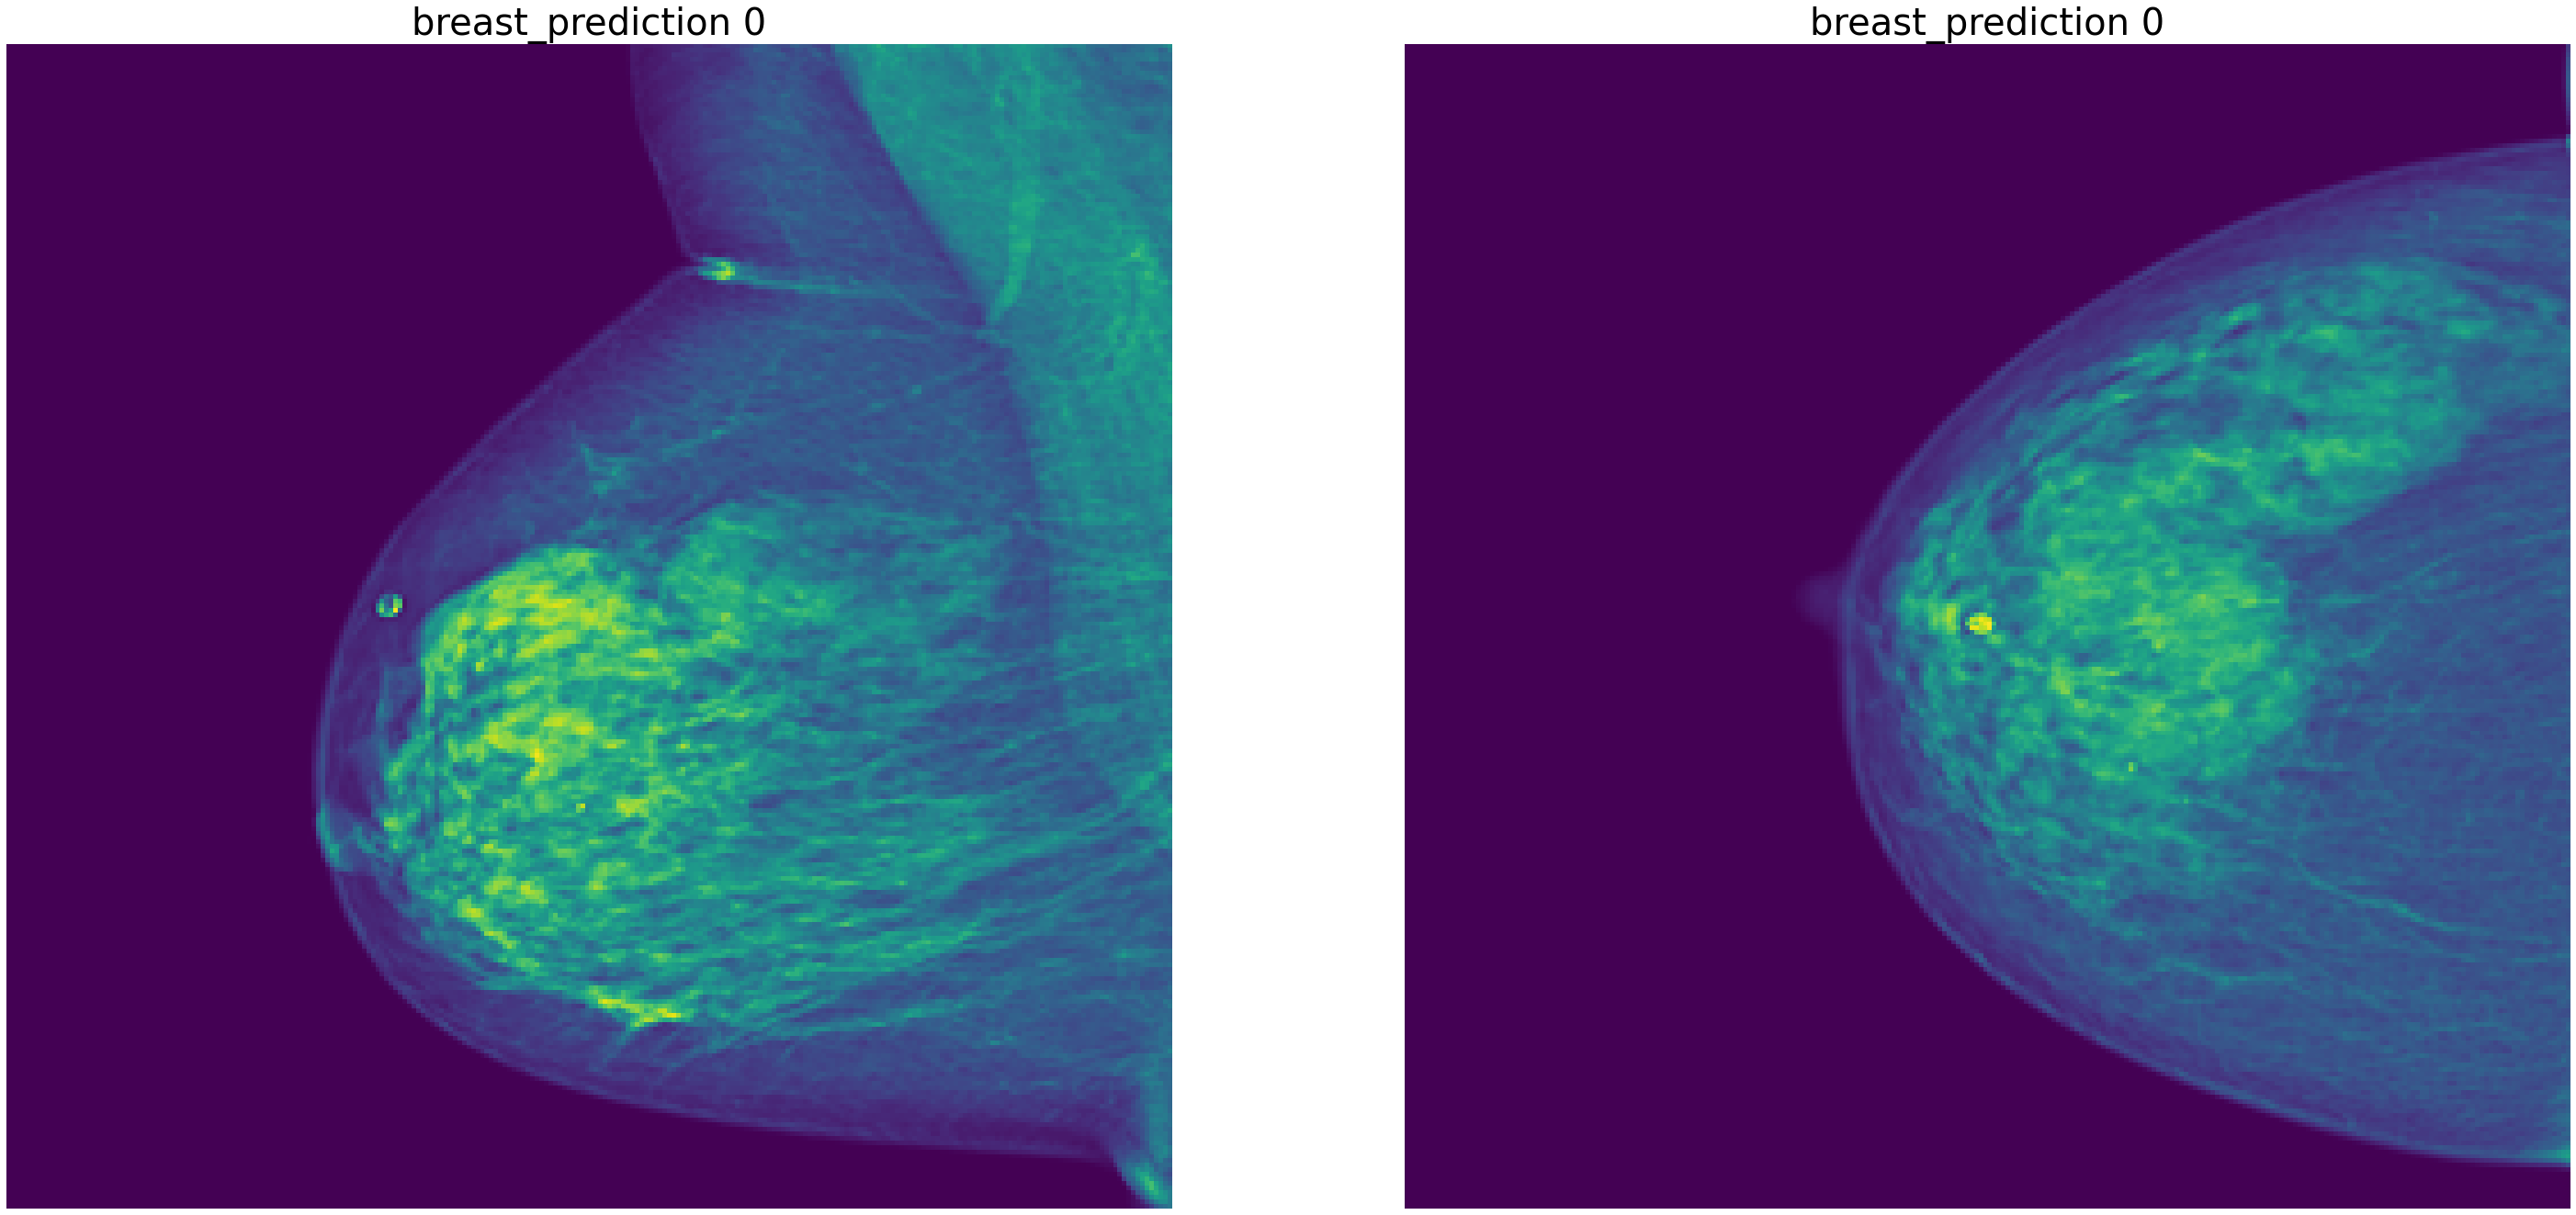

In [53]:
df_pred = pd.DataFrame(columns=['prediction_id','cancer'])
for breast_id in breasts:
    breast_prediction = -1
    breast_data = df_test[df_test['breast_id'] == breast_id]
    test_dataset = TestDataset(breast_data, image_data)
    train_dl = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=2)
    
    for batch_idx, batch in enumerate(train_dl): 
        inputs, image = batch

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            image = image.cuda()
            
        with torch.no_grad():
            model.eval()
            output = model(image, inputs)
            breast_prediction = output.argmax().cpu().item()

        fig, axs = plt.subplots(1, 2, figsize=(50, 50))
        for i, ax in enumerate(axs.flat):
            ax.imshow(image.cpu().numpy()[i][0])#, cmap='gray')
            ax.axis('off')
            ax.set_title(f'breast_prediction {breast_prediction}', fontsize=40)
        break
    
    df_pred = df_pred.append(pd.DataFrame({'prediction_id': [breast_id], 'cancer': [breast_prediction]}), ignore_index=True)

In [54]:
df_pred

prediction_id cancer
0       10008_L      0
1       10008_R      0

In [55]:
pd.DataFrame(df_pred).to_csv("submission.csv", index=False, header=True)

In [56]:
!zip -r file.zip /kaggle/working/train_images_processed_256

  adding: kaggle/working/train_images_processed_256/ (stored 0%)
  adding: kaggle/working/train_images_processed_256/10008/ (stored 0%)
  adding: kaggle/working/train_images_processed_256/10008/68070693.png (stored 0%)
  adding: kaggle/working/train_images_processed_256/10008/736471439.png (stored 0%)
  adding: kaggle/working/train_images_processed_256/10008/361203119.png (stored 0%)
  adding: kaggle/working/train_images_processed_256/10008/1591370361.png (stored 0%)
